# Page Views For Translations of Wikipedia Articles

## Install and import the required modules

In [ ]:
!pip install -r requirements.txt

In [1]:
import datetime

import matplotlib.pyplot as plt
import pandas as pd
import requests
from IPython.display import display
from ipywidgets import IntProgress

## Define functions for processing the data

In [2]:
def json_to_dataframe(json_records, date_format=None):
    '''
    Generate a DataFrame from JSON data, ensuring each value from column
    'timestamp' is treated as a datetime.
    '''
    df = pd.DataFrame.from_records(json_records)
    df['timestamp'] = pd.to_datetime(df['timestamp'], format=date_format)
    df = df.set_index('timestamp')
    return df

def get_translations_by(user, lang, project):
    '''
    Obtains a DataFrame with metadata about all articles translated by a given user.
    '''
    s = requests.Session()
    # See documentation at https://www.mediawiki.org/wiki/API:Usercontribs
    url = 'https://pt.wikipedia.org/w/api.php'
    params = {
        'action': 'query',
        'format': 'json',
        'list': 'usercontribs',
        'ucuser': user,
        'uctag': 'contenttranslation',
        'uclimit': 'max'
    }
    r = s.get(url=url, params=params)
    data = r.json()
    usercontribs = data['query']['usercontribs']
    result = json_to_dataframe(usercontribs)
    # Ensure each title appears only once, even if the translation
    # was published two or more times
    result = result.sort_index()
    result = result.drop_duplicates(subset=['title'], keep='first')
    return result

def format_date_for_api(date_str):
    '''Converts date strings from YYYY-MM-DD to YYYYMMDD.'''
    return date_str.replace('-', '')

def get_page_views(article, start_date, end_date, lang = 'pt', project = 'wikipedia'):
    '''Obtains a DataFrame with metadata about the page views of the given article.'''
    s = requests.Session()
    access = 'all-access'
    agent = 'all-agents'
    start_date = format_date_for_api(start_date)
    end_date = format_date_for_api(end_date)
    # See documentation at https://wikimedia.org/api/rest_v1/#/Pageviews%20data
    url = (f'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article'
           f'/{lang}.{project}/{access}/{agent}/{article}/daily/{start_date}/{end_date}')
    r = s.get(url=url)
    data = r.json()
    if 'items' not in data:
        return None
    page_views = data['items']
    return json_to_dataframe(page_views, date_format='%Y%m%d%H')

def get_progress_bar(n_items):
    '''Show a progress bar while the items are processed'''
    progress_bar = IntProgress(
        value=0,
        min=0,
        max=n_items,
        step=1,
        description='Processing:',
        bar_style='info',
        orientation='horizontal'
    )
    display(progress_bar)
    return progress_bar

def get_page_views_for_translations_by_user(user_name, lang, project):
    '''
    Join the time series of daily page views of all translations by the given user
    into a dataframe whose columns are the article titles.
    '''
    start_date = '2015-01-01'
    end_date = datetime.datetime.now().date().strftime('%Y-%m-%d')
    translated_articles = get_translations_by(user_name, lang, project)
    articles = []
    progress_bar = get_progress_bar(len(translated_articles))
    for timestamp, article in translated_articles[['title']].itertuples():
        progress_bar.value += 1
        page_views = get_page_views(article, start_date, end_date)
        if page_views is None:
            continue
        page_views = page_views['views'].rename(article)
        since_translation_date = page_views.index >= timestamp.strftime('%Y-%m-%d')
        articles.append(page_views[since_translation_date])
    result = pd.concat(articles, join='outer', axis=1)
    index = pd.date_range(start=start_date, end=end_date, freq='D')
    result = result.reindex(index)
    return result

def plot(df):
    '''
    Plot the time series of page views for all articles
    '''
    monthy_totals = df.resample('M').sum()
    ax = monthy_totals.plot(
        figsize=(12, 5),
        logy=True,
        title='Monthly Page Views for Each Article'
    )
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of views')
    plt.tight_layout()
    plt.show()

def sort_columns_by_average_monthly_totals(df):
    '''
    Reorder the columns from most popular to least popular articles
    (in terms of to the average number of monthly page views)
    '''
    decreasing_average_yearly_totals = df.resample('m').sum().mean().sort_values(ascending=False)
    return df.reindex(decreasing_average_yearly_totals.index, axis=1)

def plot_groups(df, articles_per_plot = 10):
    '''
    Plot the page views for groups of articles with similar number of page views
    '''
    for start in range(0, len(df.columns), articles_per_plot):
        plot(df.iloc[:, start:start + articles_per_plot])
        
def process(user_name, lang, project):
    '''
    Get, process and plot the page views data
    '''
    page_views = get_page_views_for_translations_by_user(user_name, lang, project)
    reordered = sort_columns_by_average_monthly_totals(page_views)
    plot_groups(reordered)    

## Process the translations the user published on Portuguese Wikipedia

IntProgress(value=0, bar_style='info', description='Processing:', max=87)

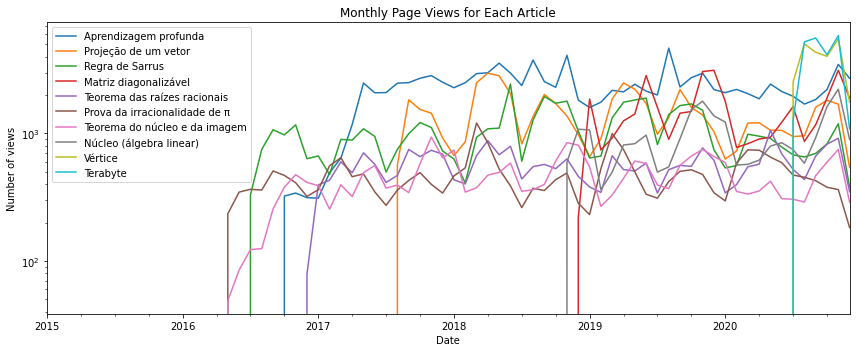

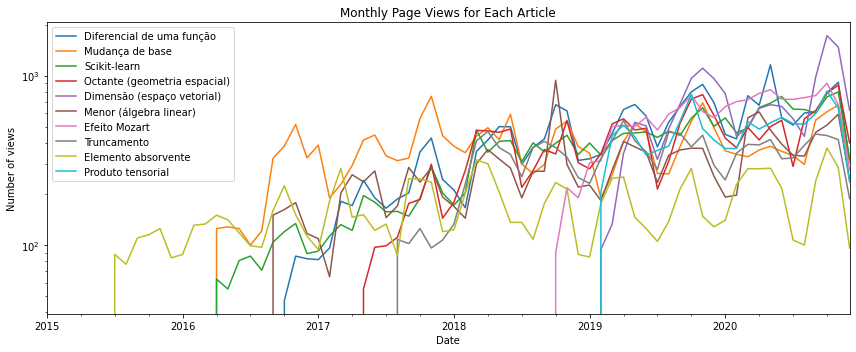

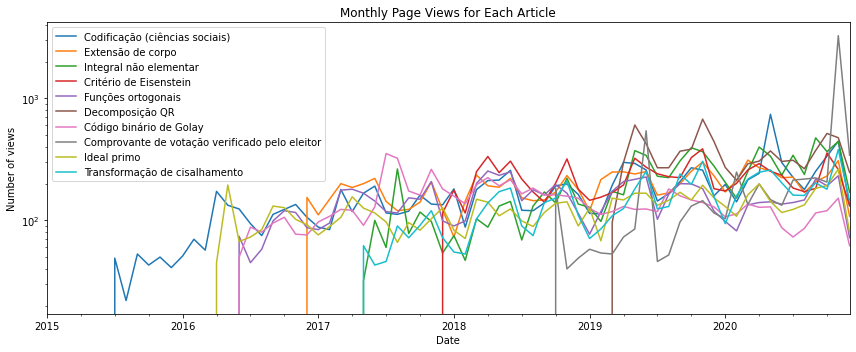

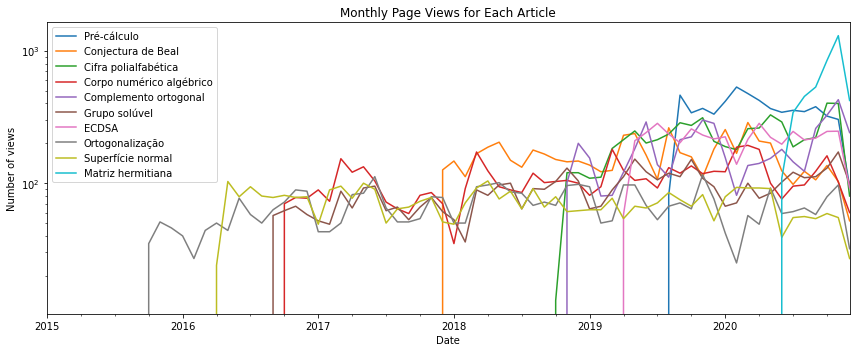

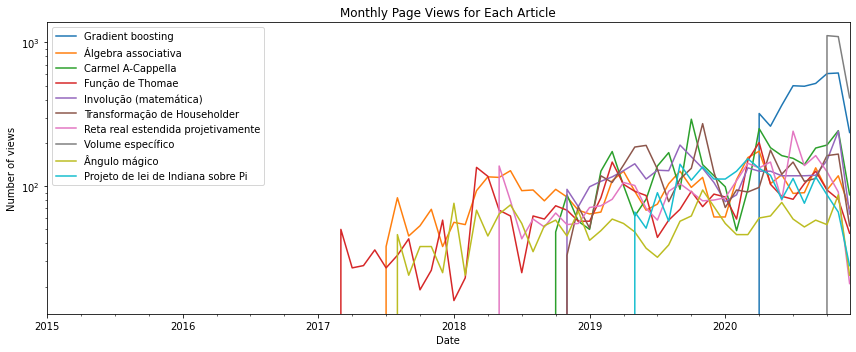

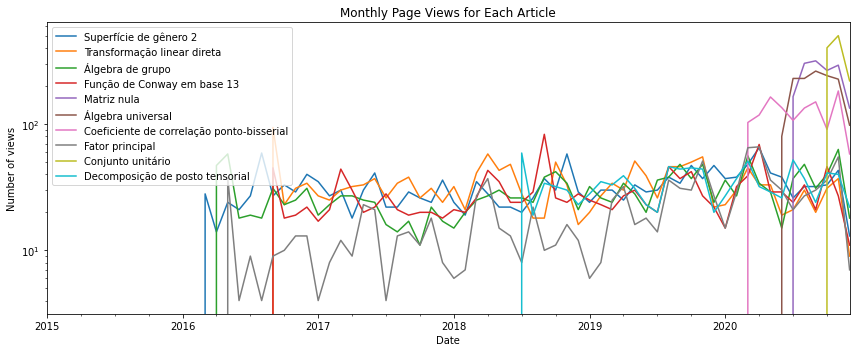

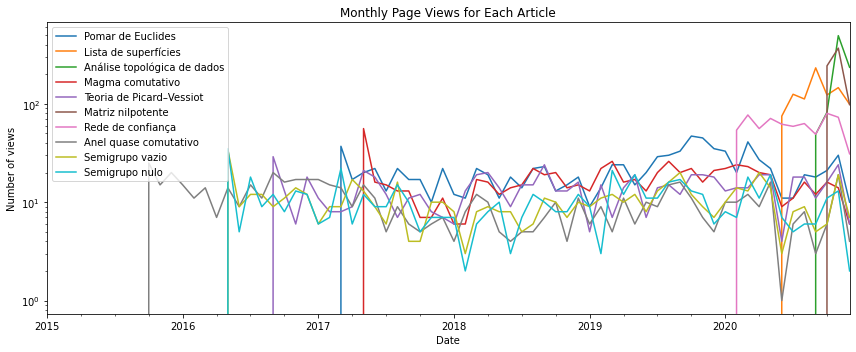

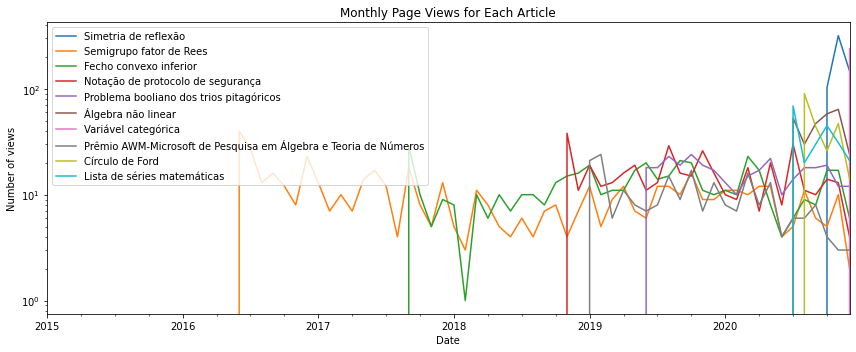

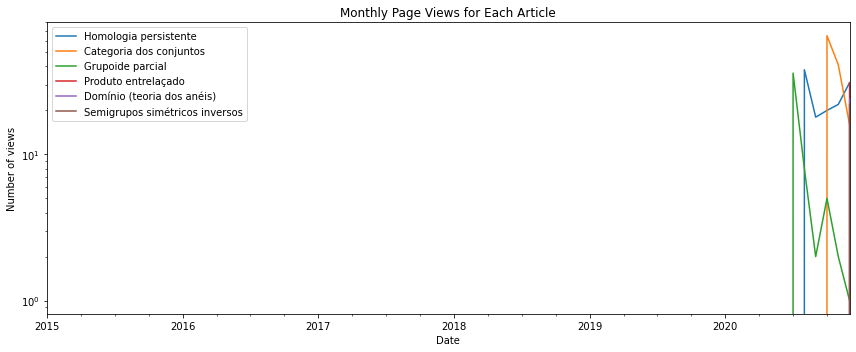

In [3]:
user_name = 'He7d3r'
lang = 'pt'
project = 'wikipedia'
process(user_name, lang, project)